In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def plot_data(update, layer, matrix, metrix, start, end, save_plot=False):

    if update:
        df = pd.read_csv(f"./data/update_layer{layer}_{matrix}_{metric}.csv")
    else:
        df = pd.read_csv(f"./data/layer{layer}_{matrix}_{metric}.csv")
    
    df_iloc = df.iloc[start:end+1]
    step = df_iloc["Step"]
    lines = [
        "jolly-sweep-1",
        "valiant-sweep-2",
        "different-sweep-3",
        "distinctive-sweep-4",
        "decent-sweep-5",
        "vivid-sweep-6",
    ]
    sns.set_style("whitegrid")
    for line in lines:
        if update:
            ax = sns.lineplot(data=df_iloc, x="Step", y=f"{line} - svd/update_layer{layer}_{matrix}/{metric}")
            min_vec = df_iloc[f"{line} - svd/update_layer{layer}_{matrix}/{metric}__MIN"]
            max_vec = df_iloc[f"{line} - svd/update_layer{layer}_{matrix}/{metric}__MAX"]
        else:
            ax = sns.lineplot(data=df_iloc, x="Step", y=f"{line} - svd/layer{layer}_{matrix}/{metric}")
            min_vec = df_iloc[f"{line} - svd/layer{layer}_{matrix}/{metric}__MIN"]
            max_vec = df_iloc[f"{line} - svd/layer{layer}_{matrix}/{metric}__MAX"]
            
        ax.set_xlabel("Step")
        ax.set_ylabel(f"{metric.replace("_", " ").title()}")

        if update:
            ax.set_title(f"Update Layer {layer} {matrix.title()} - {metric.replace("_", " ").title()} vs. Steps")
        else:
            ax.set_title(f"Layer {layer} {matrix.title()} - {metric.replace("_", " ").title()} vs. Steps")
        
        plt.fill_between(step, min_vec, max_vec, alpha=0.5)
    
    if save_plot:
        if update:
            plt.savefig(f"./plots/update_layer{layer}_{matrix}_{metric}.jpg")
        else:
            plt.savefig(f"./plots/layer{layer}_{matrix}_{metric}.jpg")
    plt.show();

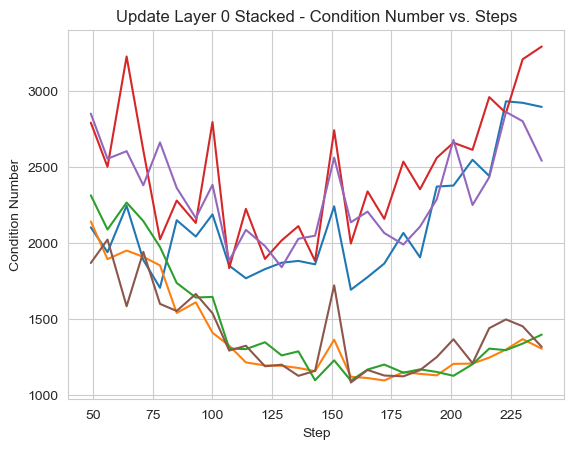

In [10]:
update = True
layer = 0
matrix = "stacked"
metric = "condition_number"
start = 6
end = 32
save_plot = True

plot_data(update, layer, matrix, metric, start, end, save_plot)

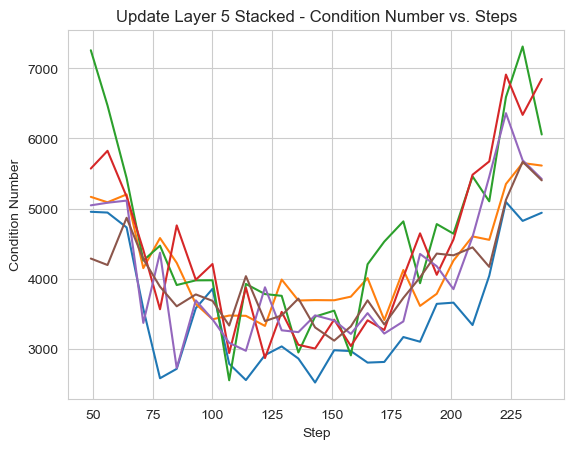

In [11]:
update = True
layer = 5
matrix = "stacked"
metric = "condition_number"
start = 6
end = 32
save_plot = True

plot_data(update, layer, matrix, metric, start, end, save_plot)

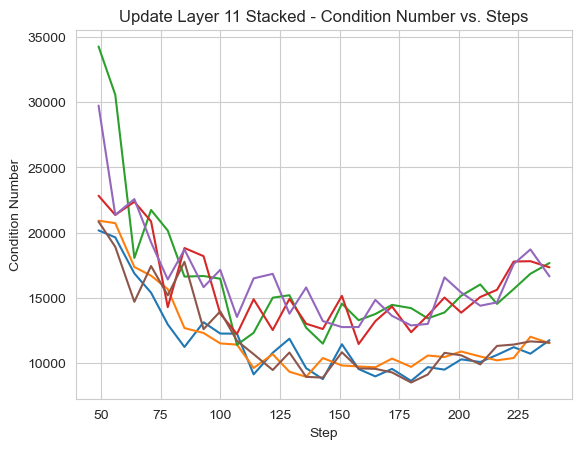

In [12]:
update = True
layer = 11
matrix = "stacked"
metric = "condition_number"
start = 6
end = 32
save_plot = True

plot_data(update, layer, matrix, metric, start, end, save_plot)